In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import classification_report, accuracy_score

# created library
import dataaugmentation
import mydata
from skindetection import SkinExtraction
from skincolors import IndividualTypologyAngle
from performance import PerformanceMeasure, PerformanceEstimation


from mymodels import TransDataset, VGG16Model
import training

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
2024-08-13 16:32:39.833363: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 16:32:39.857325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 16:32:40.462911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない

In [3]:
db = "HAM"
root = f"../../dataset/AAAI 2025/{db}/"
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test_with_skincolor.csv")

In [4]:
ycol="labels"
batch_size = 8
train_loader, valid_loader, test_loader = training.create_dataloaders(df_train, df_valid, df_test, ycol, batch_size)

H*W:  (450, 600)


Validation Accuracy: 0.6831 | Loss: 0.6093 | F1: 0.7548
Validation Accuracy: 0.7400 | Loss: 0.5819 | F1: 0.7890
Validation Accuracy: 0.7446 | Loss: 0.5695 | F1: 0.7920
Validation Accuracy: 0.7462 | Loss: 0.5410 | F1: 0.7919
Validation Accuracy: 0.7446 | Loss: 0.5558 | F1: 0.7940
Validation Accuracy: 0.8062 | Loss: 0.4120 | F1: 0.8210
Validation Accuracy: 0.7923 | Loss: 0.4262 | F1: 0.8117
Validation Accuracy: 0.7785 | Loss: 0.4743 | F1: 0.8110
Validation Accuracy: 0.7600 | Loss: 0.4907 | F1: 0.8040
Validation Accuracy: 0.7692 | Loss: 0.4486 | F1: 0.8031
Validation Accuracy: 0.7954 | Loss: 0.4518 | F1: 0.8190
Validation Accuracy: 0.7954 | Loss: 0.4194 | F1: 0.8195
Validation Accuracy: 0.8215 | Loss: 0.3815 | F1: 0.8348
Validation Accuracy: 0.7954 | Loss: 0.4576 | F1: 0.8220
Validation Accuracy: 0.8200 | Loss: 0.4040 | F1: 0.8331
Validation Accuracy: 0.7569 | Loss: 0.5921 | F1: 0.8020
Validation Accuracy: 0.8092 | Loss: 0.3944 | F1: 0.8258
Validation Accuracy: 0.8046 | Loss: 0.4359 | F1:

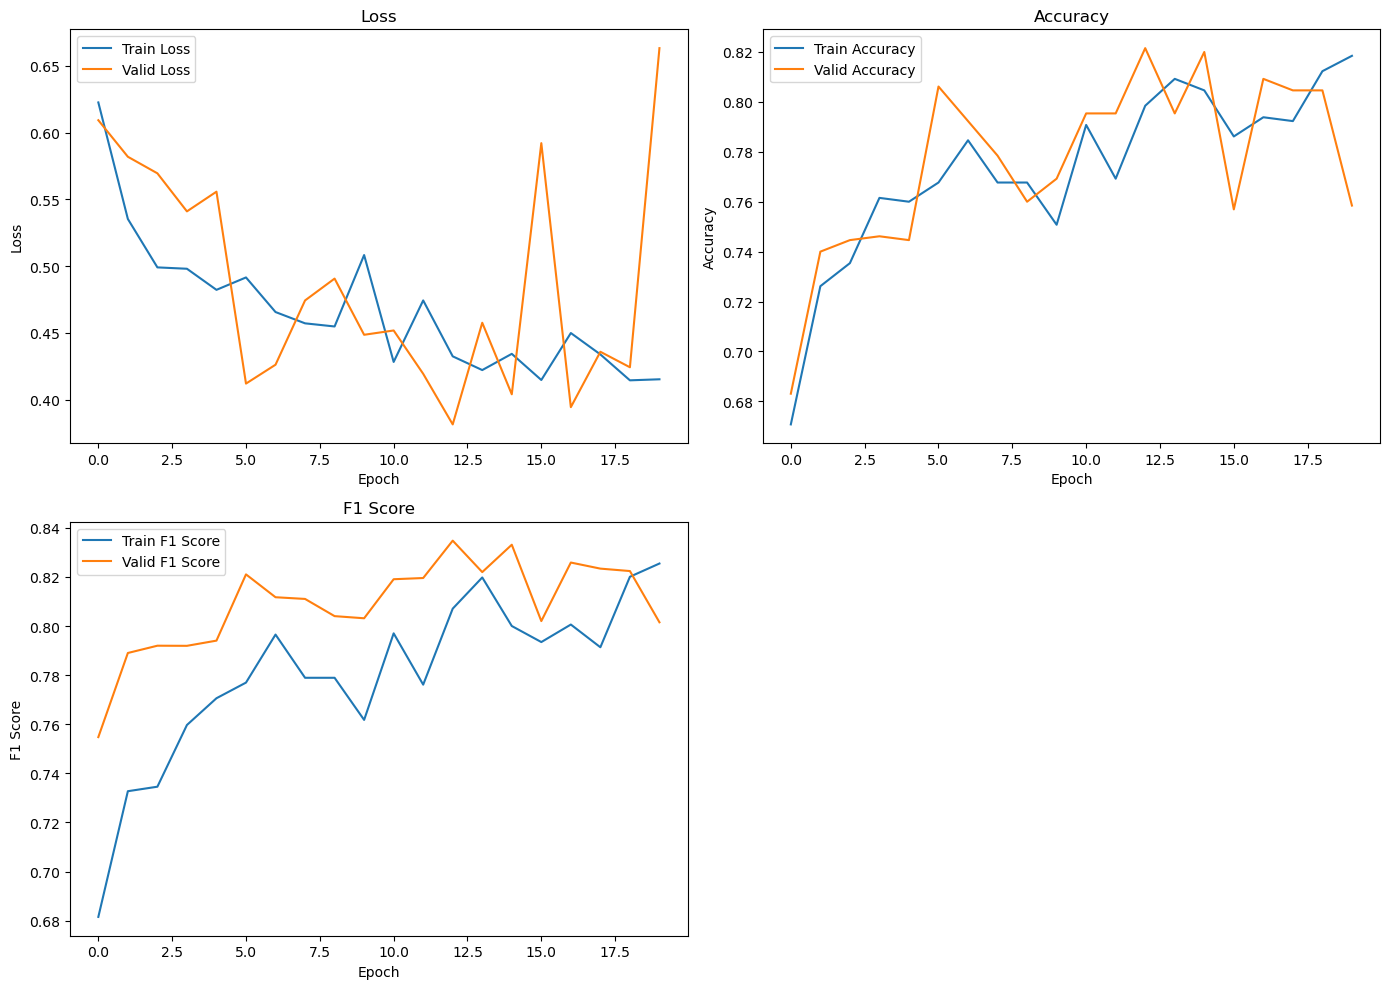

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_directory = f"{root}/model/vgg/"
model = VGG16Model().to(device) # model -> GPU

# Train the model
num_epochs = 20
lr = 0.00001
best_val_file = training.train_model(model, train_loader, valid_loader, model_save_directory, num_epochs=num_epochs, lr=lr)

## Evaluation

In [6]:
model = VGG16Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
with torch.no_grad():
    test_predictions = []
    test_outputs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
        outputs = model(inputs)
        # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
        test_outputs.append(outputs)
        test_predictions.extend(1 if x >= 0 else 0 for x in outputs) # Appendは１つ、extendは複数

df_test["predictions"] = test_predictions

In [7]:
training.test_classification_report(df_test)
df_test.to_csv(f"../../dataset/AAAI 2025/{db}/evaluation/df_test_vgg.csv", index=False)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       434
           1       0.80      0.90      0.85       434

    accuracy                           0.84       868
   macro avg       0.84      0.84      0.84       868
weighted avg       0.84      0.84      0.84       868

Skin tone 1: Accuracy 0.8375576036866359
